## Linear denoiser

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [4]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Template loading

In [5]:
uncropped = np.load(Path('~', 'data', 'cat', 'templates-jul27-only-good.npy').expanduser())

In [6]:
templates_raw = TemplatesProcessor(uncropped).crop_spatially(CONFIG.neigh_channels, CONFIG.channel_index[:, :7]).values
templates_raw = templates_raw[np.argsort(augment_util.amplitudes(templates_raw))]
templates_raw.shape

(240, 61, 7)

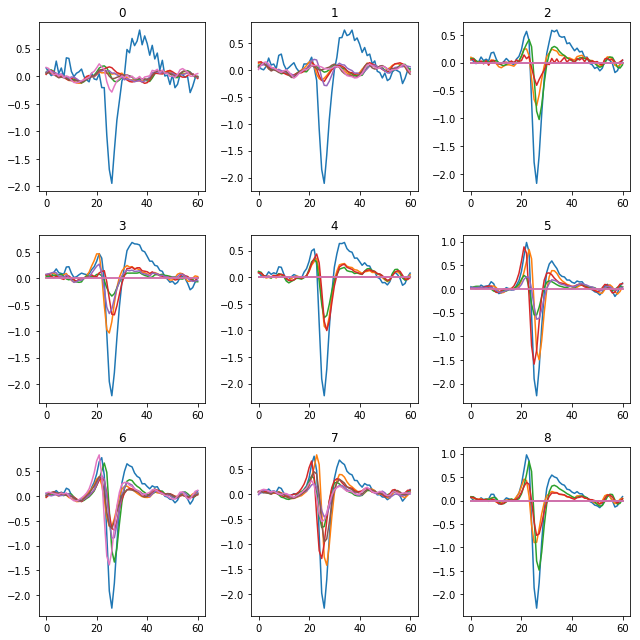

In [7]:
# should i use this small templates?
plot.grid_from_array(templates_raw, axis=0, elements=range(9), auto_figsize=3)

In [8]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

spatial_sig.shape, temporal_sig.shape

((7, 7), (61, 61))

In [9]:
# add noise
templates_noisy, _ = augment_util.add_noise(templates_raw,
                                            spatial_sig, temporal_sig,
                                            reject_cancelling_noise=True)
print(templates_noisy.shape)

(153, 61, 7)


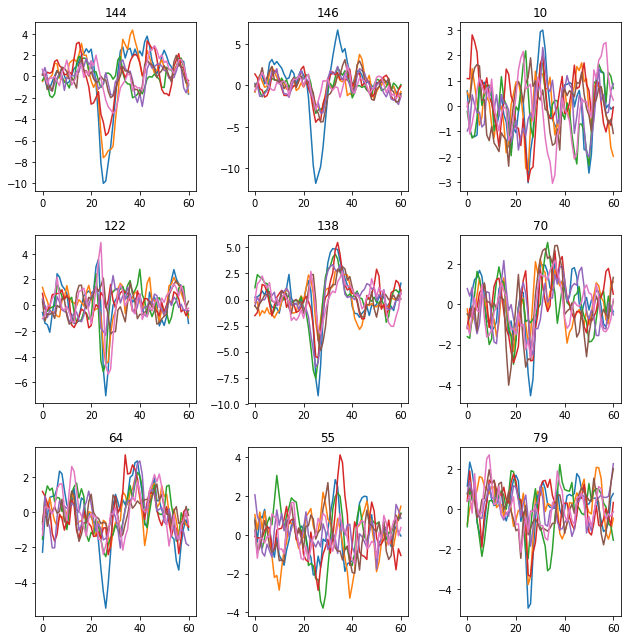

In [10]:
plot.grid_from_array(templates_noisy, axis=0, elements=9, auto_figsize=3)

## Generate testing data

In [11]:
min_amp = 5
max_amp = 10
n_clean_per_template = 20

In [12]:
dataset = Dataset.make(units_per_bin=0.5,
                       include_clean_data=True,
                       templates=templates_raw,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       n_per_template=n_clean_per_template,
                       spatial_sig=spatial_sig,
                       temporal_sig=temporal_sig,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=False,
                       make_noise=True,
                       add_noise_kwargs={'reject_cancelling_noise': True})

In [35]:
y = dataset.data
x = dataset.data_clean

y = y.reshape(y.shape[0], -1)
x = x.reshape(x.shape[0], -1)

y.shape, x.shape

((7555, 427), (7555, 427))

In [36]:
y[0].shape, y[0].T.shape

((427,), (427,))

In [39]:
m_a = np.linalg.inv(np.matmul(y.T, y))
m_a.shape

(427, 427)

In [40]:
m_b = np.matmul(y.T, x)
m_b.shape

(427, 427)

In [41]:
m = np.matmul(m_a, m_b)

In [44]:
m.shape

(427, 427)

In [53]:
x_recovered = np.matmul(m, y[100])
x_recovered.shape

(427,)

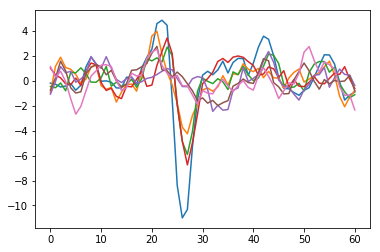

In [54]:
_ = plt.plot(y[100].reshape((61, 7)))

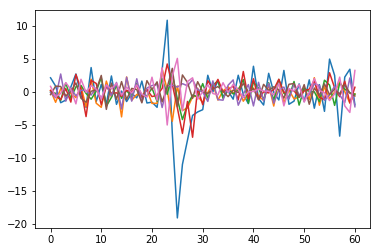

In [55]:
_ = plt.plot(x_recovered.reshape((61, 7)))

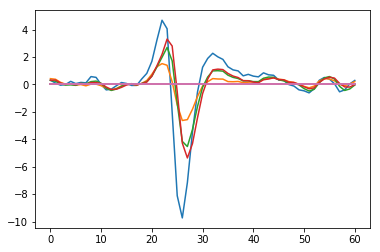

In [56]:
_ = plt.plot(x[100].reshape((61, 7)))